In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import balanced_accuracy_score

In [14]:
class CustomLDA:
    def __init__(self, class_weight_ratio=1.0):
        self.W = None
        self.B = None
        self.class_weight_ratio = class_weight_ratio

    def fit(self, X, y):
        n_samples, n_features = X.shape
        mean_class1 = np.mean(X[y == 1], axis=0)
        mean_class2 = np.mean(X[y == 2], axis=0)

        S1 = np.dot((X[y == 1] - mean_class1).T, X[y == 1] - mean_class1)
        S2 = np.dot((X[y == 2] - mean_class2).T, X[y == 2] - mean_class2)

        S1 *= self.class_weight_ratio
        within_class_scatter = S1 + S2
        self.W = np.dot(np.linalg.inv(within_class_scatter), (mean_class1 - mean_class2))
        self.B = -0.5 * np.dot(mean_class1, np.dot(np.linalg.inv(within_class_scatter), mean_class1)) + 0.5 * np.dot(mean_class2, np.dot(np.linalg.inv(within_class_scatter), mean_class2))

    def predict(self, X):
        if self.W is None or self.B is None:
            raise ValueError("The model has not been trained yet.")
        scores = np.dot(X, self.W) + self.B
        predictions = np.where(scores >= 0, 1, 2)
        return predictions

    def get_weights(self):
        return self.W

    def get_bias(self):
        return self.B

In [15]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = np.where(data.target == 0, 2, 1)  # 調整為1和2

custom_lda = CustomLDA()

# 2-Fold
def custom_cross_val_score(lda, X, y):
    n_samples = X.shape[0]
    mid_point = n_samples // 2

    # 
    X_train, X_test = X.iloc[:mid_point, :], X.iloc[mid_point:, :]
    y_train, y_test = y[:mid_point], y[mid_point:]
    lda.fit(X_train, y_train)
    predictions = lda.predict(X_test)
    score1 = balanced_accuracy_score(y_test, predictions)

    # 
    X_train, X_test = X.iloc[mid_point:, :], X.iloc[:mid_point, :]
    y_train, y_test = y[mid_point:], y[:mid_point]
    lda.fit(X_train, y_train)
    predictions = lda.predict(X_test)
    score2 = balanced_accuracy_score(y_test, predictions)

    return (score1 + score2) / 2

Step 1: Best Features: worst concave points, Score: 0.905361784693886
Step 2: Best Features: worst radius, Score: 0.9243249172942287
Step 3: Best Features: worst texture, Score: 0.9488835480931314
Step 4: Best Features: worst symmetry, Score: 0.9580736777989206
Step 5: Best Features: worst area, Score: 0.9640287795261107
Step 6: Best Features: smoothness error, Score: 0.966039290086249
Step 7: Best Features: mean area, Score: 0.969770633369831
Step 8: Best Features: radius error, Score: 0.9709174223606567
Step 9: Best Features: mean texture, Score: 0.9709174223606567
Step 10: Best Features: texture error, Score: 0.9709174223606567
Step 11: Best Features: worst compactness, Score: 0.9709174223606567
Step 12: Best Features: mean fractal dimension, Score: 0.9709174223606567
Step 13: Best Features: fractal dimension error, Score: 0.969770633369831
Step 14: Best Features: mean smoothness, Score: 0.9686238443790054
Step 15: Best Features: worst perimeter, Score: 0.9651755685169364
Step 16: B

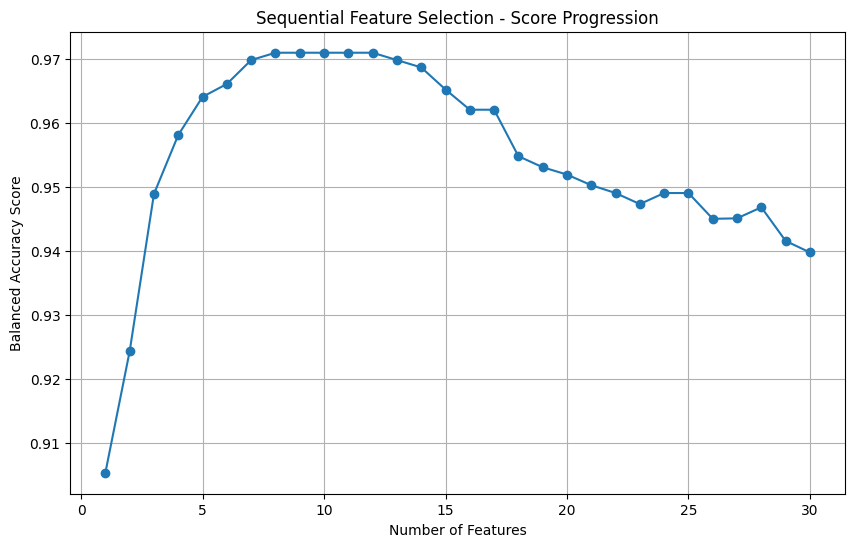

In [33]:
# SFS
def find_best_feature_subset(X, y, lda):
    remaining_features = list(X.columns)
    selected_features = []
    best_scores = []

    while remaining_features:
        best_score = 0
        best_feature = None

        for feature in remaining_features:
            trial_features = selected_features + [feature]
            score = custom_cross_val_score(lda, X[trial_features], y)

            if score > best_score:
                best_score = score
                best_feature = feature

        if best_feature:
            remaining_features.remove(best_feature)
            selected_features.append(best_feature)
            best_scores.append(best_score)
        else:
            break

    return selected_features, best_scores

# 
optimal_features, scores = find_best_feature_subset(X, y, custom_lda)

# 
for i, (features, score) in enumerate(zip(optimal_features, scores), start=1):
    print(f"Step {i}: Best Features: {features}, Score: {score}")


# Plot
steps = list(range(1, len(scores) + 1))
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Balanced Accuracy Score')
plt.title('Sequential Feature Selection - Score Progression')
plt.grid(True)
plt.show()

In [20]:
def fisher_score(X, y):
    mean_class1 = np.mean(X[y == 1], axis=0).to_numpy()  # 轉換為NumPy陣列
    mean_class2 = np.mean(X[y == 2], axis=0).to_numpy()  # 轉換為NumPy陣列

    S1 = np.dot((X[y == 1] - mean_class1).T, (X[y == 1] - mean_class1))
    S2 = np.dot((X[y == 2] - mean_class2).T, (X[y == 2] - mean_class2))
    Sw = S1 + S2  # 總散布矩陣

    # 類間
    mean_diff = (mean_class1 - mean_class2).reshape(-1, 1)
    Sb = np.dot(mean_diff, mean_diff.T)

    #
    scores = np.diag(Sb) / np.diag(Sw)
    return scores


Step 1: Feature: worst concave points, Validated Balanced Accuracy: 0.905361784693886
Step 2: Feature: worst perimeter, Validated Balanced Accuracy: 0.9226831114728308
Step 3: Feature: mean concave points, Validated Balanced Accuracy: 0.907024932543023
Step 4: Feature: worst radius, Validated Balanced Accuracy: 0.9181399354917233
Step 5: Feature: mean perimeter, Validated Balanced Accuracy: 0.9145574386482306
Step 6: Feature: worst area, Validated Balanced Accuracy: 0.9273346688795139
Step 7: Feature: mean radius, Validated Balanced Accuracy: 0.9273346688795139
Step 8: Feature: mean area, Validated Balanced Accuracy: 0.9300634659303584
Step 9: Feature: mean concavity, Validated Balanced Accuracy: 0.9264663436282001
Step 10: Feature: worst concavity, Validated Balanced Accuracy: 0.9247422056971656
Step 11: Feature: mean compactness, Validated Balanced Accuracy: 0.9230180677661312
Step 12: Feature: worst compactness, Validated Balanced Accuracy: 0.9290429890313646
Step 13: Feature: radiu

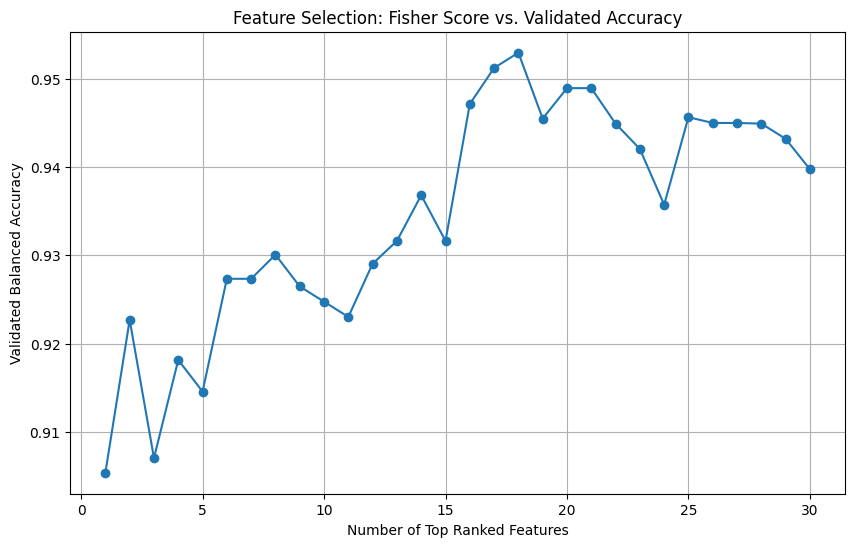

In [32]:
fisher_scores = fisher_score(X, y)

sorted_features = np.argsort(fisher_scores)[::-1]

validated_accuracies = []
best_features = []

for N in range(1, len(sorted_features) + 1):
    selected_features = X.columns[sorted_features[:N]]
    validated_accuracy = custom_cross_val_score(custom_lda, X[selected_features], y)
    validated_accuracies.append(validated_accuracy)
    best_features.append(selected_features)
    new_feature = selected_features[-1]  # 新增加的
    print(f"Step {N}: Feature: {new_feature}, Validated Balanced Accuracy: {validated_accuracy}")

# 確定最佳特徵集合
optimal_index = np.argmax(validated_accuracies)
optimal_feature_subset = best_features[optimal_index]
optimal_accuracy = validated_accuracies[optimal_index]

# 輸出集合及準確度
print("\nOptimal Feature Subset:", optimal_feature_subset.tolist())
print("Highest Validated Balanced Accuracy:", optimal_accuracy)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), validated_accuracies, marker='o')
plt.xlabel('Number of Top Ranked Features')
plt.ylabel('Validated Balanced Accuracy')
plt.title('Feature Selection: Fisher Score vs. Validated Accuracy')
plt.grid(True)
plt.show()
